## Table of Contents
<a id='section0'></a>
<div class="alert alert-block alert-info" style="margin-top: 20px">


<a href='#section1'> 1. Prepare New York dataset </a>
    
<a href='#section2'> 2. Prepare Toronto dataset</a>
    
<a href='#section3'> 3. Prepare Paris dataset</a>
    
<a href='#section4'> 4. 'Foursqure' nearby venues in three analysis cities</a>
    
<a href='#section5'> 5. Combine the datasets of three cities</a>
    
<a href='#section6'> 6. Datasets analysis</a>
    
<a href='#section7'> 7. Clustering</a>
    
</font>
</div>

Import all dependencies needed

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import re

print('Libraries imported.')

Libraries imported.


In [98]:
# create a function to output all venues nearby the specified location.

def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=101):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
CLIENT_ID = 'FOACYMUX51FQS2WK3PFCG0JDNCVCLQK2BQJ2ORMDJA2T5BFI' # your Foursquare ID
CLIENT_SECRET = 'TKK4DH2VJSWYXY53QFUFU4RBPU02ING44V0QOA1QJRKTS2T2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FOACYMUX51FQS2WK3PFCG0JDNCVCLQK2BQJ2ORMDJA2T5BFI
CLIENT_SECRET:TKK4DH2VJSWYXY53QFUFU4RBPU02ING44V0QOA1QJRKTS2T2


<a id='section1'></a>
## 1. Prepare New York dataset

<a href='#section0'> or Go back to Table of Contents </a>

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [108]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


In [109]:
neighborhoods.insert(0,'City',value='New_york',allow_duplicates = False)
neighborhoods.insert(1,'City_code',value=0,allow_duplicates = False)
all_newyork_neighborhoods=neighborhoods

In [110]:
print('the shape of dataset is {}'.format(all_newyork_neighborhoods.shape))
all_newyork_neighborhoods.head()

the shape of dataset is (306, 6)


,City,City_code,Borough,Neighborhood,Latitude,Longitude
0,New_york,0,Bronx,Wakefield,40.894705,-73.847201
1,New_york,0,Bronx,Co-op City,40.874294,-73.829939
2,New_york,0,Bronx,Eastchester,40.887556,-73.827806
3,New_york,0,Bronx,Fieldston,40.895437,-73.905643
4,New_york,0,Bronx,Riverdale,40.890834,-73.912585


In [132]:
newyork_neighborhoods_input=all_newyork_neighborhoods.sample(n=100)

<a id='section2'></a>
## 2. Prepare Toronto dataset

<a href='#section0'> or Go back to Table of Contents </a>

In [113]:
# import dataframe from file of toronto_data
toronto_df = pd.read_csv('toronto_data.csv')

# rename the columns accordingly
toronto_df.columns=['PostalCode','Borough','Neighborhood']

df_nadrop=toronto_df[toronto_df['Borough']!='Not assigned']
df_nadrop.reset_index(drop=True,inplace=True)
df_middle=df_nadrop

# set up the function to replace / with ,
def change_character(words):
    new_words=re.sub("\s/\s", ", ", words)
    return new_words

# use already built function to replace all '/' with ","
length=len(df_middle)
for i in np.arange(length):
    old=df_middle.loc[i,'Neighborhood']
    new=change_character(str(old))
    df_middle.loc[i,'Neighborhood']=str(new)

geo_inforn = pd.read_csv('Geospatial_Coordinates.csv')

df_merge=df_middle.join(geo_inforn.set_index('Postal Code'),on='PostalCode')

df_toronto_beforeinsert=df_merge.drop('PostalCode',1)

df_toronto_beforeinsert.insert(0,'City',value='Toronto',allow_duplicates=False)

df_toronto_beforeinsert.insert(1,'City_code',value=1,allow_duplicates=False)

all_toronto_neighborhoods=df_toronto_beforeinsert

C:\Users\boxin\Miniconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [114]:
print('the shape of dataset is {}'.format(all_toronto_neighborhoods.shape))

all_toronto_neighborhoods.head()

the shape of dataset is (103, 6)


,City,City_code,Borough,Neighborhood,Latitude,Longitude
0,Toronto,1,North York,Parkwoods,43.753259,-79.329656
1,Toronto,1,North York,Victoria Village,43.725882,-79.315572
2,Toronto,1,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,Toronto,1,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Toronto,1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [130]:
toronto_neighborhoods_input=all_toronto_neighborhoods.sample(n=100)

<a id='section3'></a>
## 3. Prepare Paris dataset

<a href='#section0'> or Go back to Table of Contents </a>

In [118]:
# import dataframe from file of Paris_geo, which was sourced from "https://en.wikipedia.org/wiki/Arrondissements_of_Paris" as of 12th Apr, 2020.
paris_df = pd.read_csv('paris_geo.csv')
middle_inparis=paris_df

middle_inparis.insert(0,'City',value='Paris',allow_duplicates=False)

middle_inparis.insert(1,'City_code',value=2,allow_duplicates=False)

all_paris_neighborhoods=middle_inparis

In [192]:
print('the shape of dataset is {}'.format(all_paris_neighborhoods.shape))
all_paris_neighborhoods.head()

the shape of dataset is (29, 6)


,City,City_code,Borough,Neighborhood,Latitude,Longitude
0,Paris,2,Louvre,Louvre,48.8606,2.3376
1,Paris,2,Bourse,Bourse,48.8687,2.3412
2,Paris,2,Temple,Temple,48.8659,2.3611
3,Paris,2,Hotel-de-Ville,Hotel-de-Ville,48.8534,2.3583
4,Paris,2,Pantheon,Pantheon,48.8462,2.3464


In [193]:
paris_neighborhoods_input=all_paris_neighborhoods

<a id='section4'></a>
## 4. 'Foursqure' nearby venues in three analysis cities

<a href='#section0'> or Go back to Table of Contents </a>

In [102]:
paris_venues = getNearbyVenues(names=paris_neighborhoods_input['Neighborhood'],
                                   latitudes=paris_neighborhoods_input['Latitude'],
                                   longitudes=paris_neighborhoods_input['Longitude']
                                  )

Louvre
Bourse
Temple
Hotel-de-Ville
Pantheon
Luxembourg
Palais-Bourbon
Quartier des Champs-Elysees
Quartier du Faubourg-du-Roule
Quartier de la Madeleine
Quartier de l'Europe
Opera
Entrepot
Popincourt
Reuilly
Gobelins
Observatoire
Javel
Grenelle
Necker 
Saint-Lambert
Passy
Batignolles-Monceau
Quartier de La Chapelle
Goutte d'Or
Pigalle
Montmartre
Buttes-Chaumont
Menilmontant


In [127]:
print('the shape of dataset is {}'.format(paris_venues.shape))
paris_venues.head()

the shape of dataset is (1849, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Louvre,48.8606,2.3376,Cour Carrée du Louvre,48.860360,2.338543,Pedestrian Plaza
1,Louvre,48.8606,2.3376,Musée du Louvre,48.860847,2.336440,Art Museum
2,Louvre,48.8606,2.3376,La Vénus de Milo (Vénus de Milo),48.859943,2.337234,Exhibit
3,Louvre,48.8606,2.3376,Cour Napoléon,48.861172,2.335088,Plaza
4,Louvre,48.8606,2.3376,Pont des Arts,48.858565,2.337635,Bridge


In [129]:
paris_venues.to_csv(r'C:\Users\boxin\Desktop\py4e\5_Applied_Data_Science_Capstone\paris_venues.csv',index=False)

In [135]:
newyork_venues = getNearbyVenues(names=newyork_neighborhoods_input['Neighborhood'],
                                   latitudes=newyork_neighborhoods_input['Latitude'],
                                   longitudes=newyork_neighborhoods_input['Longitude']
                                  )

East New York
Borough Park
Long Island City
Morningside Heights
Sheepshead Bay
Lenox Hill
Gravesend
Port Richmond
Morrisania
Park Hill
Battery Park City
Bellerose
Lower East Side
Mount Hope
Richmond Town
Randall Manor
Wakefield
Unionport
Van Nest
Maspeth
Crown Heights
Carnegie Hill
Broadway Junction
Greenridge
Bloomfield
Allerton
Melrose
South Side
South Beach
Washington Heights
Oakland Gardens
Neponsit
Gramercy
West Village
Downtown
Marble Hill
Ocean Hill
Kew Gardens
Upper West Side
Rockaway Park
Old Town
Graniteville
New Lots
Red Hook
West Brighton
Longwood
Midland Beach
Jackson Heights
Flatlands
Gowanus
Stapleton
Glendale
Westchester Square
Central Harlem
Claremont Village
East Elmhurst
Holliswood
College Point
Prospect Lefferts Gardens
Dumbo
Coney Island
Oakwood
Jamaica Estates
Soundview
Fulton Ferry
City Island
Woodlawn
Utopia
Hamilton Heights
Murray Hill
Hammels
Bellaire
Douglaston
Murray Hill
Soho
Hudson Yards
Tribeca
North Corona
Inwood
Clinton Hill
Arden Heights
Roosevelt Isla

In [136]:
print('the shape of dataset is {}'.format(newyork_venues.shape))
newyork_venues.head()

the shape of dataset is (3518, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,East New York,40.669926,-73.880699,Popeyes Louisiana Kitchen,40.666226,-73.882483,Fried Chicken Joint
1,East New York,40.669926,-73.880699,Caterina Pizza,40.666383,-73.883336,Pizza Place
2,East New York,40.669926,-73.880699,New Lots Ave Pedestrian Plaza,40.666245,-73.883469,Plaza
3,East New York,40.669926,-73.880699,Golden China,40.671396,-73.881421,Asian Restaurant
4,East New York,40.669926,-73.880699,Shepherd Guest House,40.671303,-73.879865,Event Service


In [137]:
newyork_venues.to_csv(r'C:\Users\boxin\Desktop\py4e\5_Applied_Data_Science_Capstone\newyork_venues.csv',index=False)

In [138]:
toronto_venues = getNearbyVenues(names=toronto_neighborhoods_input['Neighborhood'],
                                   latitudes=toronto_neighborhoods_input['Latitude'],
                                   longitudes=toronto_neighborhoods_input['Longitude']
                                  )

Dorset Park, Wexford Heights, Scarborough Town Centre
The Annex, North Midtown, Yorkville
Toronto Dominion Centre, Design Exchange
Rouge Hill, Port Union, Highland Creek
Church and Wellesley
Alderwood, Long Branch
Queen's Park, Ontario Provincial Government
New Toronto, Mimico South, Humber Bay Shores
Bayview Village
Stn A PO Boxes
Canada Post Gateway Processing Centre
Forest Hill North & West
Roselawn
Birch Cliff, Cliffside West
Bedford Park, Lawrence Manor East
Kennedy Park, Ionview, East Birchmount Park
Downsview
Moore Park, Summerhill East
Willowdale, Newtonbrook
Brockton, Parkdale Village, Exhibition Place
Lawrence Park
Little Portugal, Trinity
Willowdale
Business reply mail Processing CentrE
Steeles West, L'Amoreaux West
Berczy Park
Davisville North
Commerce Court, Victoria Hotel
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens
Cedarbrae
Bathurst Manor, Wilson Heights, Downsview North
Glencairn
W

In [139]:
print('the shape of dataset is {}'.format(toronto_venues.shape))
toronto_venues.head()

the shape of dataset is (2147, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Dorset Park, Wexford Heights, Scarborough Town...",43.75741,-79.273304,Kim Kim restaurant,43.753833,-79.276611,Chinese Restaurant
1,"Dorset Park, Wexford Heights, Scarborough Town...",43.75741,-79.273304,Kairali,43.754915,-79.276945,Indian Restaurant
2,"Dorset Park, Wexford Heights, Scarborough Town...",43.75741,-79.273304,Karaikudi Chettinad South Indian Restaurant,43.756042,-79.276276,Indian Restaurant
3,"Dorset Park, Wexford Heights, Scarborough Town...",43.75741,-79.273304,Pho Vietnam,43.757770,-79.278572,Vietnamese Restaurant
4,"Dorset Park, Wexford Heights, Scarborough Town...",43.75741,-79.273304,Big Al's Pet Supercentre,43.759279,-79.278325,Pet Store


In [140]:
toronto_venues.to_csv(r'C:\Users\boxin\Desktop\py4e\5_Applied_Data_Science_Capstone\toronto_venues.csv',index=False)

<a id='section5'></a>
## 5. Combine the datasets of three cities

<a href='#section0'> or Go back to Table of Contents </a>

In [202]:
newyork_datasets=newyork_neighborhoods_input.join(newyork_venues.set_index('Neighborhood'),on='Neighborhood')

paris_datasets=paris_neighborhoods_input.join(paris_venues.set_index('Neighborhood'),on='Neighborhood')

toronto_datasets=toronto_neighborhoods_input.join(toronto_venues.set_index('Neighborhood'),on='Neighborhood')

In [203]:
newyork_paris_datasets=pd.concat([newyork_datasets,paris_datasets])
all_datasets=pd.concat([newyork_paris_datasets,toronto_datasets])
all_datasets.reset_index(drop=True,inplace=True)
print("the shape of the dataframe merging all three cities' data together is {}".format(all_datasets.shape))

the shape of the dataframe merging all three cities' data together is (7776, 12)


<a id='section6'></a>
## 6. Datasets analysis

<a href='#section0'> or Go back to Table of Contents </a>

In [534]:
onehot=pd.get_dummies(all_datasets[['Venue Category']], prefix="", prefix_sep="")

# drop the column'neighborhood'
onehot.drop(['Neighborhood'],axis=1,inplace=True)

# insert the neighborhood column into onehot's first column
onehot.insert(0,'Neighborhood',all_datasets['Neighborhood'],allow_duplicates = True)
onehot.insert(1,'City',all_datasets['City'],allow_duplicates = True)
onehot.insert(2,'City_code',all_datasets['City_code'],allow_duplicates = True)
onehot.insert(3,'Borough',all_datasets['Borough'],allow_duplicates = True)

print('the shape of the onehot is {}'.format(onehot.shape))
onehot.head()

#onehot['City_code'].value_counts()

the shape of the onehot is (7776, 421)


,Neighborhood,City,City_code,Borough,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Basque Restaurant,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Lyonese Bouchon,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,

In [535]:
analysis_group=onehot.drop(['City','City_code','Borough'],axis=1).groupby('Neighborhood').mean().reset_index()
print('the shape of group is {}'.format(analysis_group.shape))
analysis_group.head(10)

the shape of group is (223, 418)


,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Basque Restaurant,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Lyonese Bouchon,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Gr

In [546]:
left_group=analysis_group[['Neighborhood']]
print(left_group.shape)

right_group=onehot[['Neighborhood','City_code','Borough']]
print(right_group.shape)

(223, 1)
(7776, 3)


In [549]:
left_group.insert(1,'City_code',value=5)
left_group.insert(2,'Borough',value='New')

for i,item in enumerate(left_group.Neighborhood):
    solution1=right_group[right_group['Neighborhood']==item].iloc[0][1]
    solution=right_group[right_group['Neighborhood']==item].iloc[0][2]
    left_group['City_code'][i]=solution1
    left_group['Borough'][i]=solution


C:\Users\boxin\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\boxin\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\boxin\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [550]:
print(left_group.shape)

left_group['City_code'].value_counts()

(223, 3)


0    99
1    95
2    29
Name: City_code, dtype: int64

In [557]:
left_group.head(10)

,Neighborhood,City_code,Borough
0,Agincourt,1,Scarborough
1,"Alderwood, Long Branch",1,Etobicoke
2,Allerton,0,Bronx
3,Arden Heights,0,Staten Island
4,"Bathurst Manor, Wilson Heights, Downsview North",1,North York
5,Batignolles-Monceau,2,Batignolles-Monceau
6,Battery Park City,0,Manhattan
7,Bay Ridge,0,Brooklyn
8,Bayside,0,Queens
9,Bayswater,0,Queens


In [559]:
analysis_group.drop('City_code',axis=1,inplace=True)
analysis_group.insert(1,'City_code',left_group['City_code'])

analysis_group.drop('Borough',axis=1,inplace=True)
analysis_group.insert(2,'Borough',left_group['Borough'])

In [561]:
analysis_group['City_code'].value_counts()

0    99
1    95
2    29
Name: City_code, dtype: int64

In [562]:
analysis_group.head(10)

,Neighborhood,City_code,Borough,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Basque Restaurant,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Lyonese Bouchon,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optic

In [566]:
analysis_group.shape

(223, 420)

In [563]:
# create a function to return the 10 most frequent venues for each neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [571]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = analysis_group['Neighborhood']

for ind in np.arange(analysis_group.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(analysis_group.iloc[ind, 3:], num_top_venues)

print('the shape of neighborhoods_venues_sorted is {}'.format(neighborhoods_venues_sorted.shape))
neighborhoods_venues_sorted.head(10)

the shape of neighborhoods_venues_sorted is (223, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Breakfast Spot,Clothing Store,Latin American Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
1,"Alderwood, Long Branch",Pizza Place,Pub,Coffee Shop,Pool,Gym,Sandwich Place,Skating Rink,Dance Studio,Pharmacy,Dumpling Restaurant
2,Allerton,Pizza Place,Chinese Restaurant,Department Store,Deli / Bodega,Supermarket,Cosmetics Shop,Gas Station,Donut Shop,Electronics Store,Martial Arts Dojo
3,Arden Heights,Pharmacy,Bus Stop,Deli / Bodega,Coffee Shop,Pizza Place,Yoga Studio,Falafel Restaurant,Electronics Store,Empanada Restaurant,English Restaurant
4,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Ice Cream Shop,Video Store,Gas Station,Chinese Restaurant,Sandwich Place,Shopping Mall,Sushi Restaurant,Diner
5,Batignolles-Monceau,French Restaurant,Hotel,Italian Restaurant,Bakery,Moroccan Restaurant,Argentinian Restaurant,Pizza Place,Sandwich Place,Breakfast Spot,Mediterranean Restaurant
6,Battery Park City,Park,Hotel,Coffee Shop,Memorial Site,Gym,Boat or Ferry,Plaza,Grocery Store,Italian Restaurant,Gourmet Shop
7,Bay Ridge,Italian Restaurant,Spa,Pizza Place,Greek Restaurant,Bar,American Restaurant,Sushi Restaurant,Ice Cream Shop,Playground,Sandwich Place
8,Bayside,Bar,Mexican Restaurant,Pizza Place,Sushi Restaurant,American Restaurant,Indian Restaurant,Bakery,Italian Restaurant,Pub,Donut Shop
9,Bayswater,Park,Playground,Yoga Studio,Farm,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space


<a id='section7'></a>
## 7. Clustering

<a href='#section0'> or Go back to Table of Contents </a>

In [572]:
# set number of clusters
kclusters = 5

all_group_cluster = analysis_group.drop('Neighborhood', 1).drop('City_code',1).drop('Borough',1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_group_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [573]:
fr=[analysis_group[['Neighborhood','City_code','Borough']],neighborhoods_venues_sorted.iloc[:,1:]]

final=pd.concat(fr,axis=1,sort=False)

In [574]:
final.insert(2,'Assigned_cluster_index',kmeans.labels_)

In [575]:
final['Assigned_cluster_index'].value_counts()

1    202
0     14
3      5
4      1
2      1
Name: Assigned_cluster_index, dtype: int64

In [576]:
final.head()

,Neighborhood,City_code,Assigned_cluster_index,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,1,1,Scarborough,Lounge,Skating Rink,Breakfast Spot,Clothing Store,Latin American Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
1,"Alderwood, Long Branch",1,1,Etobicoke,Pizza Place,Pub,Coffee Shop,Pool,Gym,Sandwich Place,Skating Rink,Dance Studio,Pharmacy,Dumpling Restaurant
2,Allerton,0,1,Bronx,Pizza Place,Chinese Restaurant,Department Store,Deli / Bodega,Supermarket,Cosmetics Shop,Gas Station,Donut Shop,Electronics Store,Martial Arts Dojo
3,Arden Heights,0,1,Staten Island,Pharmacy,Bus Stop,Deli / Bodega,Coffee Shop,Pizza Place,Yoga Studio,Falafel Restaurant,Electronics Store,Empanada Restaurant,English Restaurant
4,"Bathurst Manor, Wilson Heights, Downsview North",1,1,North York,Bank,Coffee Shop,Ice Cream Shop,Video Store,Gas Station,Chinese Restaurant,Sandwich Place,Shopping Mall,Sushi Restaurant,Diner


In [577]:
c1=final[final['Assigned_cluster_index']==1]['City_code'].value_counts()
c1

0    96
1    78
2    28
Name: City_code, dtype: int64

In [578]:
c0=final[final['Assigned_cluster_index']==0]['City_code'].value_counts()
c0

1    11
0     2
2     1
Name: City_code, dtype: int64

In [579]:
c2=final[final['Assigned_cluster_index']==2]['City_code'].value_counts()
c2

1    1
Name: City_code, dtype: int64

In [580]:
c3=final[final['Assigned_cluster_index']==3]['City_code'].value_counts()
c3

1    4
0    1
Name: City_code, dtype: int64

In [581]:
c4=final[final['Assigned_cluster_index']==4]['City_code'].value_counts()
c4

1    1
Name: City_code, dtype: int64

In [582]:
# define the dataframe columns
column_names1 = ['City_code','City', 'Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4'] 

# instantiate the dataframe
output_analysis = pd.DataFrame(columns=column_names1)

output_analysis['City_code']=np.arange(3)
output_analysis['City']=list(['New_york','Toronto','Paris'])
output_analysis['Cluster 0']=[2/99,11/95,1/29]
output_analysis['Cluster 1']=[96/99,78/95,28/29]
output_analysis['Cluster 2']=[0/99,1/95,0/29]
output_analysis['Cluster 3']=[1/99,4/95,0/29]
output_analysis['Cluster 4']=[0/99,1/95,0/29]

output_analysis

,City_code,City,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,0,New_york,0.020202,0.969697,0.000000,0.010101,0.000000
1,1,Toronto,0.115789,0.821053,0.010526,0.042105,0.010526
2,2,Paris,0.034483,0.965517,0.000000,0.000000,0.000000


In [583]:
new=output_analysis.T.iloc[2:,]
new=new.rename(columns={0: "New_york", 1: "Toronto", 2: "Paris"}, errors="raise")
new

,New_york,Toronto,Paris
Cluster 0,0.020202,0.115789,0.0344828
Cluster 1,0.969697,0.821053,0.965517
Cluster 2,0,0.0105263,0
Cluster 3,0.010101,0.0421053,0
Cluster 4,0,0.0105263,0


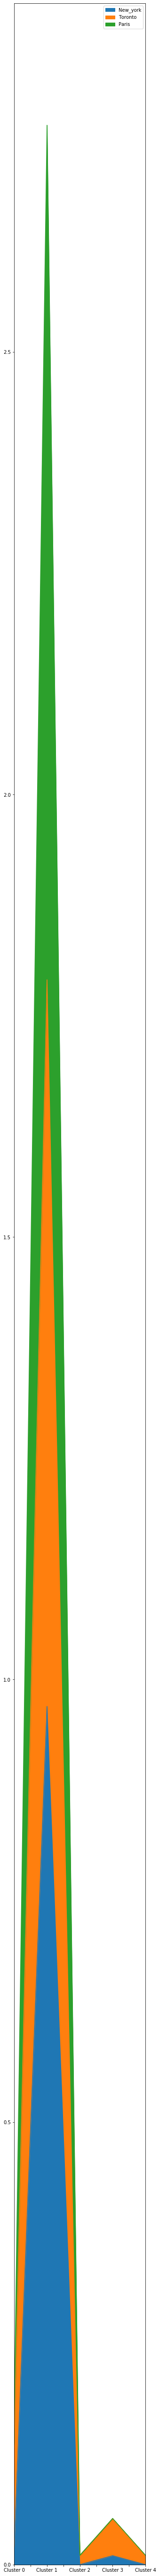

In [520]:
new.plot(kind='area',figsize=(5,100))

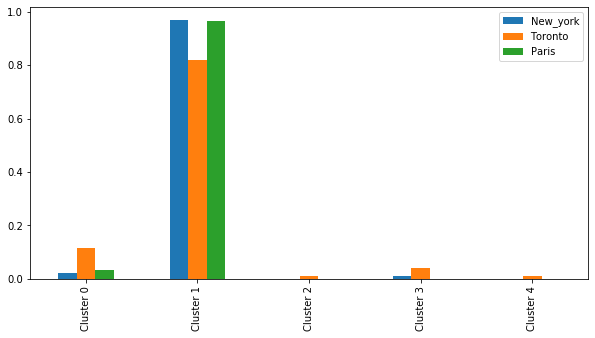

In [584]:
new.plot(kind='bar',figsize=(10,5))

In [589]:
#select all datasets in cluster 1
a=final[final['Assigned_cluster_index']==1]

#select all datasets in New_york
b=a[a['City_code']==0]

#select all datasets in Manhattan
c=b[b['Borough']=='Manhattan']
c

,Neighborhood,City_code,Assigned_cluster_index,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Battery Park City,0,1,Manhattan,Park,Hotel,Coffee Shop,Memorial Site,Gym,Boat or Ferry,Plaza,Grocery Store,Italian Restaurant,Gourmet Shop
28,Carnegie Hill,0,1,Manhattan,Coffee Shop,Café,Yoga Studio,Japanese Restaurant,Italian Restaurant,Gym,Gym / Fitness Center,Pizza Place,Bakery,Cosmetics Shop
31,Central Harlem,0,1,Manhattan,French Restaurant,African Restaurant,Seafood Restaurant,Chinese Restaurant,American Restaurant,Bar,Bagel Shop,Park,Boutique,Gym / Fitness Center
74,Gramercy,0,1,Manhattan,Bar,Pizza Place,Italian Restaurant,American Restaurant,Coffee Shop,Mexican Restaurant,Playground,Ice Cream Shop,Grocery Store,Cocktail Bar
81,Hamilton Heights,0,1,Manhattan,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Deli / Bodega,Sandwich Place,Sushi Restaurant,Cocktail Bar,Bakery,Liquor Store
89,Hudson Yards,0,1,Manhattan,American Restaurant,Gym / Fitness Center,Hotel,Italian Restaurant,Thai Restaurant,Park,Gym,Spanish Restaurant,Coffee Shop,Dog Run
94,Inwood,0,1,Manhattan,Mexican Restaurant,Café,Pizza Place,Lounge,Restaurant,Frozen Yogurt Shop,Bakery,American Restaurant,Chinese Restaurant,Deli / Bodega
108,Lenox Hill,0,1,Manhattan,Italian Restaurant,Coffee Shop,Pizza Place,Sushi Restaurant,Cocktail Bar,Café,Gym / Fitness Center,Burger Joint,Gym,Cycle Studio
113,Lower East Side,0,1,Manhattan,Chinese Restaurant,Coffee Shop,Ramen Restaurant,Pizza Place,Café,Art Gallery,Cocktail Bar,Bakery,Yoga Studio,Filipino Restaurant
116,Marble Hill,0,1,Manhattan,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place


In [593]:
#select all datasets in cluster 1
a=final[final['Assigned_cluster_index']==1]

#select all datasets containing Toronto name
d=a.loc[a['Borough'].isin(['Downtown Toronto','East Toronto','West Toronto','Central Toronto'])]

#select all datasets in Downtown Toronto
f=d.loc[d['Borough']=='Downtown Toronto']
f

,Neighborhood,City_code,Assigned_cluster_index,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Berczy Park,1,1,Downtown Toronto,Coffee Shop,Café,Cheese Shop,Beer Bar,Italian Restaurant,Farmers Market,Restaurant,Bakery,Cocktail Bar,Seafood Restaurant
25,"CN Tower, King and Spadina, Railway Lands, Har...",1,1,Downtown Toronto,Airport Lounge,Airport Service,Airport Terminal,Bar,Boutique,Coffee Shop,Plane,Boat or Ferry,Rental Car Location,Harbor / Marina
30,Central Bay Street,1,1,Downtown Toronto,Coffee Shop,Italian Restaurant,Café,Middle Eastern Restaurant,Sandwich Place,Japanese Restaurant,Thai Restaurant,Salad Place,Burger Joint,Gym / Fitness Center
32,Christie,1,1,Downtown Toronto,Grocery Store,Café,Park,Restaurant,Candy Store,Coffee Shop,Athletics & Sports,Gas Station,Diner,Baby Store
33,Church and Wellesley,1,1,Downtown Toronto,Coffee Shop,Gay Bar,Japanese Restaurant,Sushi Restaurant,Restaurant,Yoga Studio,Café,Gastropub,Mediterranean Restaurant,Men's Store
40,"Commerce Court, Victoria Hotel",1,1,Downtown Toronto,Coffee Shop,Café,Restaurant,Hotel,Gym,American Restaurant,Japanese Restaurant,Gastropub,Italian Restaurant,Deli / Bodega
61,"First Canadian Place, Underground city",1,1,Downtown Toronto,Coffee Shop,Café,Restaurant,American Restaurant,Steakhouse,Japanese Restaurant,Asian Restaurant,Gym,Gastropub,Seafood Restaurant
67,"Garden District, Ryerson",1,1,Downtown Toronto,Clothing Store,Coffee Shop,Cosmetics Shop,Café,Italian Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Bubble Tea Shop,Restaurant,Bookstore
83,"Harbourfront East, Union Station, Toronto Islands",1,1,Downtown Toronto,Coffee Shop,Aquarium,Café,Hotel,Italian Restaurant,Restaurant,Sporting Goods Shop,Fried Chicken Joint,Scenic Lookout,Brewery
101,"Kensington Market, Chinatown, Grange Park",1,1,Downtown Toronto,Vietnamese Restaurant,Café,Coffee Shop,Bar,Mexican Restaurant,Vegetarian / Vegan Restaurant,Farmers Market,Dessert Shop,Grocery Store,Gaming Cafe


In [597]:
#select all datasets in cluster 1
a=final[final['Assigned_cluster_index']==1]

#select all datasets containing Toronto name
g=a[a['City_code']==2]

#select all datasets in three boroughs where data density is high
i=g.loc[g['Borough'].isin(['Butte-Montmartre','Elysee','Vaugirard'])]

,Neighborhood,City_code,Assigned_cluster_index,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
72,Goutte d'Or,2,1,Butte-Montmartre,French Restaurant,Bistro,Supermarket,Bakery,Chinese Restaurant,Fast Food Restaurant,Hotel,Theater,Café,Convenience Store
79,Grenelle,2,1,Vaugirard,French Restaurant,Hotel,Japanese Restaurant,Bakery,Bistro,Cheese Shop,Italian Restaurant,Creperie,Gym / Fitness Center,Indian Restaurant
99,Javel,2,1,Vaugirard,French Restaurant,Hotel,Japanese Restaurant,Supermarket,Bike Rental / Bike Share,Pizza Place,Asian Restaurant,Fast Food Restaurant,Bistro,Metro Station
123,Montmartre,2,1,Butte-Montmartre,French Restaurant,Italian Restaurant,Bar,Plaza,Bistro,Bakery,Pizza Place,Park,Coffee Shop,Garden
130,Necker,2,1,Vaugirard,Hotel,French Restaurant,Korean Restaurant,Café,Dessert Shop,Italian Restaurant,Bakery,Pet Café,Gourmet Shop,Ethiopian Restaurant
153,Pigalle,2,1,Butte-Montmartre,French Restaurant,Hotel,Bakery,Bar,Italian Restaurant,Japanese Restaurant,Cocktail Bar,Coffee Shop,Plaza,Chinese Restaurant
158,Quartier de La Chapelle,2,1,Butte-Montmartre,Asian Restaurant,Supermarket,Thai Restaurant,Soccer Field,Chinese Restaurant,French Restaurant,Mexican Restaurant,Theater,Gym Pool,Sushi Restaurant
159,Quartier de l'Europe,2,1,Elysee,Hotel,French Restaurant,Italian Restaurant,Café,Bistro,Cosmetics Shop,Pizza Place,Salad Place,Sushi Restaurant,Restaurant
160,Quartier de la Madeleine,2,1,Elysee,French Restaurant,Hotel,Boutique,Women's Store,Gourmet Shop,Dessert Shop,Clothing Store,Garden,Men's Store,Park
161,Quartier des Champs-Elysees,2,1,Elysee,French Restaurant,Boutique,Hotel,Steakhouse,Italian Restaurant,Clothing Store,Bistro,Plaza,Art Gallery,Women's Store


In [599]:
# To open up business in areas where many venues are densely located
# in Manhattan
b.groupby('Borough').count()

,Neighborhood,City_code,Assigned_cluster_index,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,,,,
Bronx,16,16,16,16,16,16,16,16,16,16,16,16,16
Brooklyn,21,21,21,21,21,21,21,21,21,21,21,21,21
Manhattan,18,18,18,18,18,18,18,18,18,18,18,18,18
Queens,24,24,24,24,24,24,24,24,24,24,24,24,24
Staten Island,17,17,17,17,17,17,17,17,17,17,17,17,17


In [600]:
d.groupby('Borough').count()

,Neighborhood,City_code,Assigned_cluster_index,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,,,,
Central Toronto,7,7,7,7,7,7,7,7,7,7,7,7,7
Downtown Toronto,18,18,18,18,18,18,18,18,18,18,18,18,18
East Toronto,5,5,5,5,5,5,5,5,5,5,5,5,5
West Toronto,6,6,6,6,6,6,6,6,6,6,6,6,6


In [601]:
g.groupby('Borough').count()

,Neighborhood,City_code,Assigned_cluster_index,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,,,,
Batignolles-Monceau,1,1,1,1,1,1,1,1,1,1,1,1,1
Bourse,1,1,1,1,1,1,1,1,1,1,1,1,1
Butte-Montmartre,4,4,4,4,4,4,4,4,4,4,4,4,4
Buttes-Chaumont,1,1,1,1,1,1,1,1,1,1,1,1,1
Elysee,4,4,4,4,4,4,4,4,4,4,4,4,4
Entrepot,1,1,1,1,1,1,1,1,1,1,1,1,1
Gobelins,1,1,1,1,1,1,1,1,1,1,1,1,1
Hotel-de-Ville,1,1,1,1,1,1,1,1,1,1,1,1,1
Louvre,1,1,1,1,1,1,1,1,1,1,1,1,1
